In [22]:
import pandas as pd
import numpy as np
from ipynb.fs.full.extracao import damage_matrix, Types, pokedex_df_filtered
import matplotlib.pyplot as plt
from imageio.v2 import imread
from mpl_toolkits.axes_grid1 import ImageGrid
pokedex_df_filtered_with_predict = pd.read_pickle('./pokedex_df_filtered_with_predict.pkl')

# Gerador de times

Agora iremos arrumar um jeito de encontrar um Pokemon com o tipo complementar ao meu Pokemon incial e montar o time baseado na nossa "role" de batalha gerada no outro notebook.

Sabendo quais as fraquezas e efetividades do meu pokemon, irei buscar:
- 2 pokemons imunes (ou resistentes) as fraquezas do meu inicial. Irei escolher as fraquezes que são mais usadas no competitivo.
- 3 pokemons superefetivos contra as fraquezas do meu inicial. Irei escolher as fraquezes que são mais usadas no competitivo.

Irei usar algum critério randomico para escolher tipos diferents para essas duas categorias e gerar mais de uma opção de time.  
Por exemplo, para o Charizard posso escolher 3 Pokemons imunes aos tipos:
- Water
- Ground
- Ice  

ou

- Rock
- Eletric
- Water

## Implementando

In [27]:
def validate_if_mon_choice_exists(desired_role, desired_type):
    choices = pokedex_df_filtered_with_predict[(pokedex_df_filtered_with_predict.role == desired_role) & (pokedex_df_filtered_with_predict.type1 == Types(desired_type).name)]

    return len(choices) > 0

def generate_team(pokemon_name):
    pokemon = pokedex_df_filtered_with_predict[pokedex_df_filtered_with_predict.name == pokemon_name]
    pokemon_role = pokemon.role.values[0]
    desired_roles = np.array(['tank' ,'tank', 'attacker', 'attacker', 'spattacker', 'spattacker'])
    desired_roles = np.delete(desired_roles, np.where(desired_roles == pokemon_role)[0][0])

    desired_defensive_roles = desired_roles[:2]
    desired_offensive_roles = desired_roles[2:]

    rng = np.random.default_rng()
    type1 = Types[pokemon.type1.values[0]]
    type2 = pokemon.type2.values[0]

    pokemon_types = [type1]
    if type2 is not None:
        pokemon_types.append(Types[type2])

    damage_multipliers = np.empty(18)
    damage_multipliers.fill(1)
    for cur_type in pokemon_types:
        damage_multipliers_def = damage_matrix[:, cur_type.value]
        for i in range(len(damage_multipliers_def)):
            damage_multipliers[i] = damage_multipliers[i] * damage_multipliers_def[i]



    four_x_weak = np.argwhere(damage_multipliers == 4).flatten() ## Tipos que meu pokemon recebe 4x mais dano nos ataques
    two_x_weak = np.argwhere(damage_multipliers == 2).flatten() ## Tipos que meu pokemon recebe 2x mais dano nos ataques

    if len(four_x_weak) == 2:
        weak_types = np.concatenate([rng.choice(four_x_weak, size = 2, replace=False)])
    elif len(four_x_weak) == 1:
        weak_types = np.concatenate([rng.choice(four_x_weak, size = 1, replace=False), rng.choice(two_x_weak, size = 1, replace=False)])
    else:
        if len(two_x_weak) == 1:
            weak_types = [two_x_weak[0], two_x_weak[0]]
        else:
            weak_types = np.concatenate([rng.choice(two_x_weak, size = 2, replace=False)])

    resistent_against_my_weak = np.array([])
    # print("Escolhendo tipos de pokemons defensivos")
    # print(f"{pokemon_name} é fraco contra: {[Types(i).name for i in weak_types]}")

    for i in range(len(weak_types)):
        curr_resistent_type = None
        damage_multiplier_def = damage_matrix[weak_types[i]]
        immune_to = np.argwhere(damage_multiplier_def == 0.0).flatten()
        rng.shuffle(immune_to)
        resistent_to = np.argwhere(damage_multiplier_def == 0.5).flatten()
        rng.shuffle(resistent_to)
        # print(f"{[Types(j).name  for j in immune_to]} é imune contra: {  Types(weak_types[i]).name}")
        # print(f"{[Types(j).name  for j in resistent_to]} é fraco contra: {  Types(weak_types[i]).name}")


        if len(immune_to) > 0:
            curr_resistent_type = next((j for j in immune_to if validate_if_mon_choice_exists(desired_type = j, desired_role =  desired_defensive_roles[i])), None)
        if len(immune_to) == 0 or curr_resistent_type is None:
            # print(f"validando se existe {desired_defensive_roles[i]} do tipo {[Types(j).name  for j in resistent_to]}")
            curr_resistent_type = next((j for j in resistent_to if validate_if_mon_choice_exists(desired_type = j, desired_role =  desired_defensive_roles[i]) and j not in resistent_against_my_weak), None)
        resistent_against_my_weak = np.append(resistent_against_my_weak, curr_resistent_type)

    # print("Tipos defensivos escolhidos:")
    # print([Types(i).name for i in resistent_against_my_weak])
    strong_against_my_weak = np.array([])

    if len(four_x_weak) == 2:
        weak_types = np.concatenate([rng.choice(four_x_weak, size = 2, replace=False), rng.choice(two_x_weak, size = 1, replace=False)])
    elif len(four_x_weak) == 1:
        if len(two_x_weak) == 1:
            weak_types = np.concatenate([rng.choice(four_x_weak, size = 1, replace=False), np.array([two_x_weak[0], two_x_weak[0]])])
        else:
            weak_types = np.concatenate([rng.choice(four_x_weak, size = 1, replace=False), rng.choice(two_x_weak, size = 2, replace=False)])
    else:
        if len(two_x_weak) == 1:
            weak_types = np.array([two_x_weak[0], two_x_weak[0], two_x_weak[0]])
        elif len(two_x_weak) == 2:
            weak_types = np.array([two_x_weak[0], two_x_weak[0], two_x_weak[1]])
        else:
            weak_types = np.concatenate([rng.choice(two_x_weak, size = 3, replace=False)])
    print("\n")
    print("Escolhendo tipos de pokemons ofensivos")
    print(f"{pokemon_name} é fraco contra: {[Types(i).name for i in weak_types]}")

    for i in range(len(weak_types)):
        damage_multiplier_atk = damage_matrix[:, weak_types[i]]
        strong_against = np.argwhere(damage_multiplier_atk == 2.).flatten()
        rng.shuffle(strong_against)
        print(f"{[Types(j).name  for j in strong_against]} é forte contra: {  Types(weak_types[i]).name}")
        print(f"validando se existe {desired_offensive_roles[i]} do tipo {[Types(j).name  for j in strong_against]}")
        choice = next((j for j in strong_against if validate_if_mon_choice_exists(desired_type= j, desired_role= desired_offensive_roles[i]) and j not in strong_against_my_weak), None)

        if choice is None:
            print("Não existe")
            continue
        print(f"Escolhido: {Types(choice).name}")
        strong_against_my_weak = np.append(strong_against_my_weak, choice)
    if len(strong_against_my_weak) < 3:
        fill = np.empty(3)
        fill.fill(strong_against_my_weak[0])
        strong_against_my_weak = np.concatenate([strong_against_my_weak, fill])[:3]
    print("Tipos ofensivos escolhidos:")
    print([Types(i).name for i in strong_against_my_weak])
    pkmn1 = pokedex_df_filtered_with_predict[(pokedex_df_filtered_with_predict.role == desired_defensive_roles[0]) &
                                             (pokedex_df_filtered.type1 == Types(resistent_against_my_weak[0]).name)].sample(1)
    pkmn2 = pokedex_df_filtered_with_predict[(pokedex_df_filtered_with_predict.role == desired_defensive_roles[1]) &
                                             (pokedex_df_filtered.type1 == Types(resistent_against_my_weak[1]).name)].sample(1)



    pkmn3 = pokedex_df_filtered_with_predict[(pokedex_df_filtered_with_predict.role == desired_offensive_roles[0]) &
                                             (pokedex_df_filtered.type1 == Types(strong_against_my_weak[0]).name)].sample(1)
    pkmn4 = pokedex_df_filtered_with_predict[(pokedex_df_filtered_with_predict.role == desired_offensive_roles[1]) &
                                             (pokedex_df_filtered.type1 == Types(strong_against_my_weak[1]).name)].sample(1)
    pkmn5 = pokedex_df_filtered_with_predict[(pokedex_df_filtered_with_predict.role == desired_offensive_roles[2]) &
                                             (pokedex_df_filtered.type1 == Types(strong_against_my_weak[2]).name)].sample(1)

    return pd.concat([pokemon, pkmn1, pkmn2, pkmn3, pkmn4, pkmn5]).reset_index()

In [29]:
teams = []
for i in range(4):
    teams.append(generate_team("infernape"))
## TODO: capturar cobertura de superefetivos/fraquezas de cada time e passar por um modelo para checar qual é o melhore
## TODO: ajeitar para charizard, blastoise etc



Escolhendo tipos de pokemons ofensivos
infernape é fraco contra: ['flying', 'psychic', 'water']
['rock', 'electric', 'ice'] é forte contra: flying
validando se existe attacker do tipo ['rock', 'electric', 'ice']
Escolhido: rock
['ghost', 'dark', 'bug'] é forte contra: psychic
validando se existe spattacker do tipo ['ghost', 'dark', 'bug']
Escolhido: ghost
['grass', 'electric'] é forte contra: water
validando se existe spattacker do tipo ['grass', 'electric']
Escolhido: grass
Tipos ofensivos escolhidos:
['rock', 'ghost', 'grass']


Escolhendo tipos de pokemons ofensivos
infernape é fraco contra: ['psychic', 'flying', 'ground']
['dark', 'ghost', 'bug'] é forte contra: psychic
validando se existe attacker do tipo ['dark', 'ghost', 'bug']
Escolhido: dark
['electric', 'ice', 'rock'] é forte contra: flying
validando se existe spattacker do tipo ['electric', 'ice', 'rock']
Escolhido: electric
['ice', 'grass', 'water'] é forte contra: ground
validando se existe spattacker do tipo ['ice', 'gr

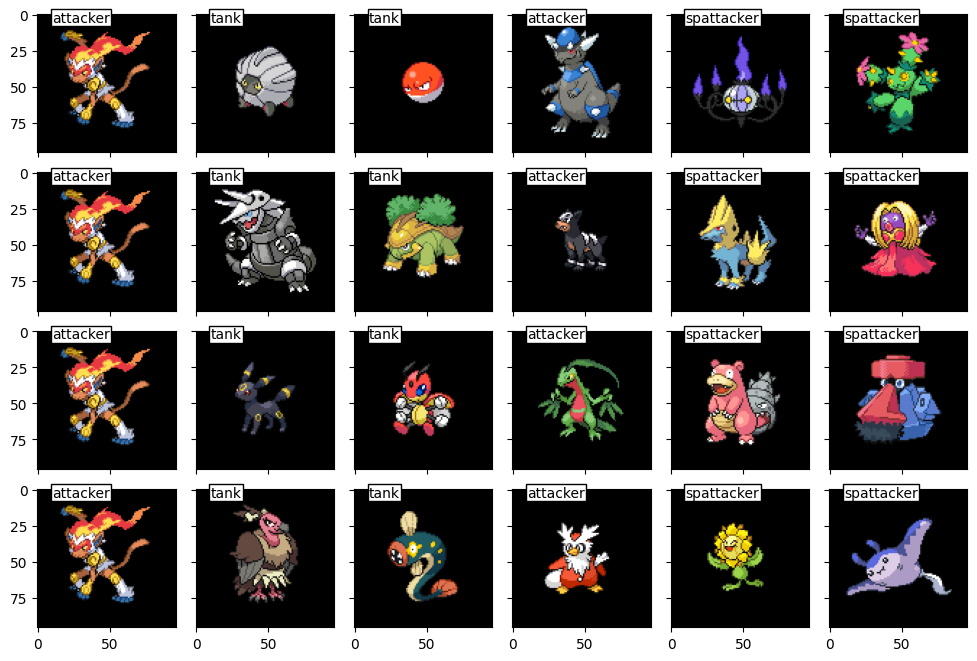

In [30]:
fig = plt.figure(figsize=(12., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(len(teams), 6),  # creates 2x2 grid of axes
                 axes_pad=0.2,  # pad between axes in inch.
                 )

cnt = 0
for team_idx in range(len(teams)):

    for i, pokemon in teams[team_idx].iterrows():
        image_url = pokemon["image_url"]
        image_file = imread(image_url)
        name = pokemon["name"]
        role = pokemon["role"]
        grid[cnt].text(10, 5, role, bbox={'facecolor': 'white', 'pad': 1})
        grid[cnt].imshow(image_file)
        cnt += 1

plt.show()